Elaborado por: Yurley Tatiana Prieto
               y Juan Jose Ardila

# Clasificación de clases y segmentación con K-Mean

Para este trabajo se realizó un análisis de una zona del noreste de Colombia, donde es posible detallar distintas coberturas y que permite entrenar distintos modelos.

A continuación, se muestran los pasos realizados para lograr estos procesos con los modelos de Random Forest con K-Mean como covariable.


## Importación de modulos

In [1]:
# Standard and scientific libraries
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import rasterio.windows as rwin
from rasterio.mask import mask

# Machine-learning tools
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Image-enhancement for visual interpretation
from skimage.exposure import equalize_adapthist

import geopandas as gpd
import os


## Cargar conjuntos de datos y generar un subconjunto de trabajo

Previo a la generación de la clasifiación no supervisada con el algortimo K-Mean, se prepara la información del área de estudio, sin embargo, para este caso se genera un área de interes, la cual contiene una alta cantidad de muestreos para realizar la clasificación, reduciendo así el área original, para evitar un sobregasto de computo.


In [2]:
# Ruta base
m_root = '/notebooks/Workshop_5'
raster_path = os.path.join(m_root, 'datos/sentinel_median_16bit.tif')
subset_path = os.path.join(m_root, 'subset_by_shape.tif')

In [122]:
# Cargar shapefile o GPKG
aoi = gpd.read_file(os.path.join(m_root, 'datos/new_layer.shp'))

with rio.open(raster_path) as src:
    aoi = aoi.to_crs(src.crs)
    out_image, out_transform = mask(src, aoi.geometry, crop=True)
    out_meta = src.meta.copy()

out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform,
    "compress": "lzw",
    "tiled": True
})

# Guardar el subset
with rio.open(subset_path, "w", **out_meta) as dest:
    dest.write(out_image)

print("Subset recortado por shapefile guardado en →", subset_path)

# Mostrar metadatos clave
print("Subset metadata summary:")
print(f"  Dimensions    → {out_meta['width']} × {out_meta['height']} px")
print(f"  Band count    → {out_meta['count']} bands")
print(f"  CRS           → {out_meta['crs']}")
print(f"  Data type     → {out_meta['dtype']}")
print(f"  Transform     →\n    {out_meta['transform']}")


Subset recortado por shapefile guardado en → /notebooks/Workshop_5/subset_by_shape.tif
Subset metadata summary:
  Dimensions    → 2961 × 4072 px
  Band count    → 9 bands
  CRS           → EPSG:3116
  Data type     → int16
  Transform     →
    | 10.00, 0.00, 1168140.00|
| 0.00,-10.00, 1251470.00|
| 0.00, 0.00, 1.00|


## Previsualización de los datos

Es posible, detallar como se relacionan los valores de reflectancia de los pixeles de las bandas de la imagen original, que se detallan en la siguiente tabla mediante un diagrama de dispersión.

| **Banda Sentinel-2** | **Banda relativa** | **Descripción**                   |
| -------------------- | ------------------ | --------------------------------- |
| **B2**               | Banda 1            | Azul                              |
| **B3**               | Banda 2            | Verde                             |
| **B4**               | Banda 3            | Rojo                              |
| **B5**               | Banda 4            | Red edge 1                        |
| **B6**               | Banda 5            | Red edge 2                        |
| **B7**               | Banda 6            | Red edge 3                        |
| **B8**               | Banda 7            | Infrarrojo cercano (NIR)          |
| **B11**              | Banda 8            | Infrarrojo de onda corta (SWIR 1) |
| **B12**              | Banda 9            | Infrarrojo de onda corta (SWIR 2) |

Adicionalmente, se genera una combinación en color verdadero, para detallar el área definida de estudio y dar una identificaicón inical de los elementos presentes. Esto se complementa con un suvie estiramiento lineal, que ayuda a equilibrar la imagen, que ayuda a evitar los valore satipicos, que tambien son visibles en el digrama de dispersión.



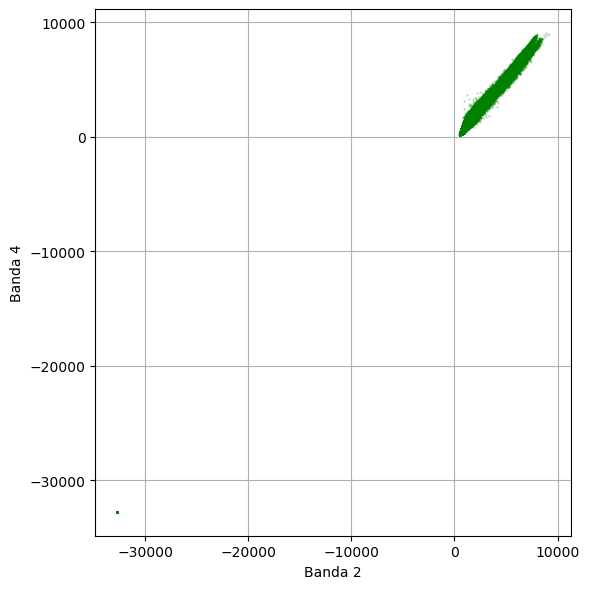

In [123]:
# Abrir imagen raster
with rio.open(subset_path) as src:
    banda2 = src.read(1).astype(float)  # por ejemplo: banda verde
    banda4 = src.read(3).astype(float)  # por ejemplo: banda roja

# Aplanar las bandas
x = banda2.flatten()
y = banda4.flatten()



# Crear scatterplot
plt.figure(figsize=(6, 6))
plt.scatter(x, y, s=0.3, alpha=0.3, color='green')
plt.xlabel("Banda 2")
plt.ylabel("Banda 4")
# plt.title("Scatterplot: Banda 2 vs Banda 4")
plt.grid(True)
plt.tight_layout()
plt.show()


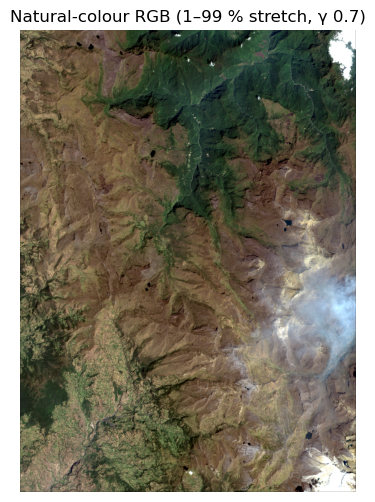

In [124]:
#· RGB preview (bands 4-3-2 )
with rio.open(subset_path) as src:
    img = src.read()

bands_rgb = (3, 2, 1)                            # R-G-B (1-based)
gamma     = 0.7                                 # contrast tweak

channels = []
for b in bands_rgb:
    band = img[b-1].astype(float)
    lo, hi = np.percentile(band, (1, 99))
    band = np.clip((band - lo) / (hi - lo), 0, 1)
    channels.append(band)

rgb = np.dstack(channels) ** gamma

plt.figure(figsize=(6, 6))
plt.imshow(rgb)
plt.title("Natural-colour RGB (1–99 % stretch, γ 0.7)")
plt.axis("off")
plt.show()


## Clase ClusteredStack

Estas funciones definidas encapsulan el proceso de la clasifiación no supervisada con el formato par K-Mean.


In [3]:
# %% Listings 5-7 completos (adaptados)
class ClusteredStack:
    
    def __init__(self, raster_path): # Initialises the class instance.
        self.raster_path = raster_path # path to the multiband GeoTIFF (e.g., the 400×400 subset).  
        self.model_input = None #    the reshaped data matrix  
        self.height = self.width = self.depth = 0 # image dimensions
        self.k_range = [] # List of all k-values (number of clusters) to evaluate
        self.models = [] # Trained KMeans models for each k; stored for later inspection
        self.predicted_rasters = [] # Cluster label images (reshaped to raster size)
        self.inertia_scores = [] # Inertia values (sum of squared distances within clusters); used for Elbow method
        self.silhouette_scores = [] # Silhouette scores (measure of cluster separation); used for model selection

    
    def set_raster_stack(self):
        """Reads the raster and reshapes it into a format suitable for K-Means."""
        with rio.open(self.raster_path) as src:

            # Read all bands into a 3D NumPy array of shape (bands, rows, cols)
            stack = src.read()

             # Replace any NaN (Not-a-Number) values with zero. Avoids errors during clustering algorithms, which cannot handle NaNs
            stack = np.nan_to_num(stack)   
        # Extract the number of bands, rows, and columns from the raster's shape
        # These values are stored as object attributes for later use
        self.depth, self.height, self.width = stack.shape

        # Reshape the 3D array into a 2D matrix of shape (n_pixels, n_bands)
        # Each row now corresponds to one pixel, and each column to a spectral band
        # Transposition (.T) ensures the matrix has the correct shape for scikit-learn
        self.model_input = stack.reshape(self.depth, -1).T


    def build_models(self, k_values):
        """
            Trains one K-Means clustering model for each value of k provided in k_values.
         It stores the resulting models, cluster labels, and evaluation metrics.
        """

        # Convert the input iterable into a list and store it
        # This list defines the number of clusters to be tested (e.g. [3, 4, 5, ..., 10])
        self.k_range = list(k_values)

        # Initialise empty lists to store models, results, and metrics
        self.models, self.predicted_rasters = [], [] # Trained KMeans objects  - Cluster label images (reshaped to raster form)
        self.inertia_scores, self.silhouette_scores = [], [] # Inertia values for each k - # Silhouette scores for each k

        for k in self.k_range:

            # Create a KMeans model with k clusters
            # random_state ensures reproducibility; n_init specifies how many times the algorithm will run with different centroid seeds
            km = KMeans(n_clusters=k, random_state=42, n_init=10)

             # Fit the model to the reshaped raster and predict the cluster labels
             # This returns one label (cluster ID) per pixel
            labels = km.fit_predict(self.model_input)

            # Store the trained model
            self.models.append(km)

            # Record the inertia for this k (lower is better; used in Elbow method)
            self.inertia_scores.append(km.inertia_)

            # Calculate and store the silhouette score for this k
            # A higher silhouette score indicates better-defined clusters
            # Sampling is limited to 1000 points for performance reasons
            self.silhouette_scores.append(
                silhouette_score(self.model_input, labels, sample_size=1000)
            )

            # Reshape the flat list of labels back to image form (rows × cols)
            # This is required for visualising the classified image later
            self.predicted_rasters.append(labels.reshape(self.height, self.width))


    def show_clustered(self, cmap="Accent"):
        """
        Displays one classified raster image for each value of k.
        Each image uses a categorical colourmap for easy interpretation.
        """
        for k, img_cls in zip(self.k_range, self.predicted_rasters):
            plt.figure(figsize=(5, 5))
            plt.imshow(img_cls, cmap=cmap)
            plt.title(f"{k} clusters")
            plt.axis("off")
            plt.colorbar()
            plt.show()

    def show_inertia(self):
        """
        Plots the inertia values for each k to apply the Elbow method.
        Inertia measures how tightly the data points are clustered around their centroids.
        Lower values indicate more compact clusters.
        """
        plt.figure(figsize=(5, 4))
        plt.plot(self.k_range, self.inertia_scores, "o-")
        plt.xlabel("Number of clusters (k)")
        plt.ylabel("Inertia")
        plt.title("Elbow method")
        plt.show()

    def show_silhouette(self):
        """
        Plots the silhouette scores for each k to assess clustering quality.
        Silhouette score ranges from -1 to 1, with higher values indicating
        better-defined, well-separated clusters.
        """
        plt.figure(figsize=(5, 4))
        plt.plot(self.k_range, self.silhouette_scores, "o-")
        plt.xlabel("Número de clusters (k)")
        plt.ylabel("Silhouette Coeff.s")
        plt.title("Silhouette scores")
        plt.show()


Posteriomente, es aqui donde se genera el entrenamiento para la imagen con el algortimo definido de K-Means probando las K 
entre 3 a 10 y obteniendo dos metricas, una de inercia y la segunda de silhouette.Means.



In [4]:
clustered_models = ClusteredStack(subset_path)

clustered_models.set_raster_stack()

ranges = np.arange(3, 11, 1)

clustered_models.build_models(ranges)


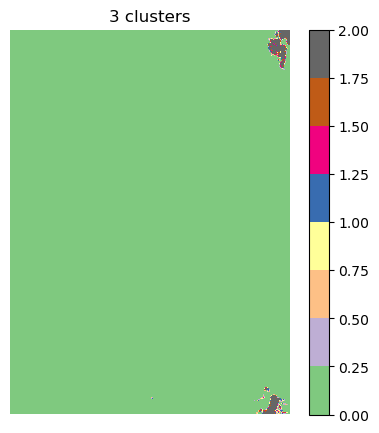

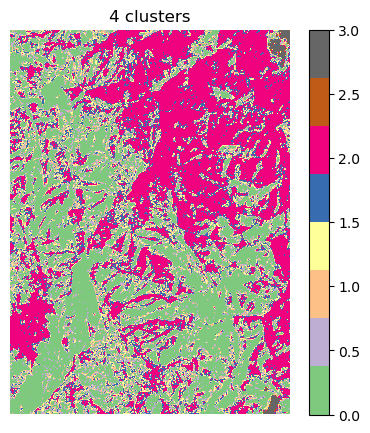

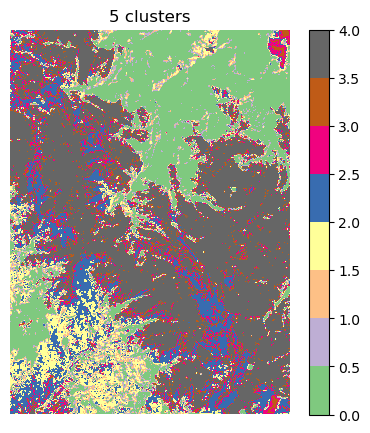

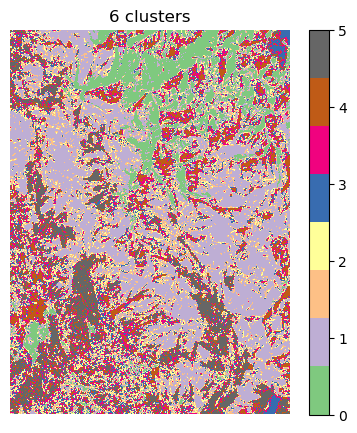

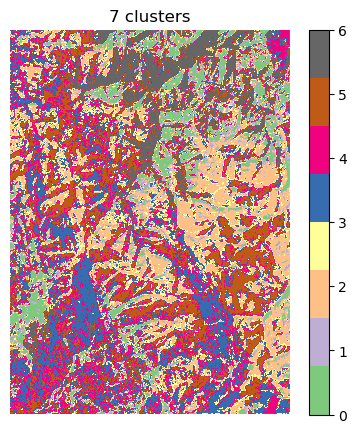

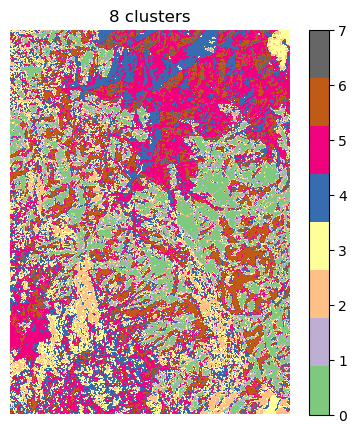

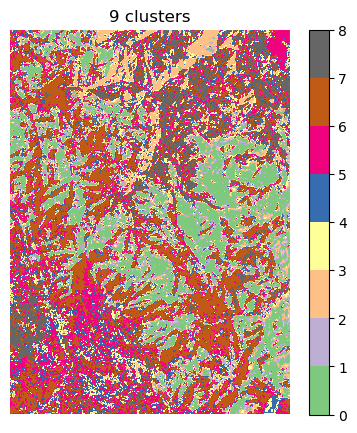

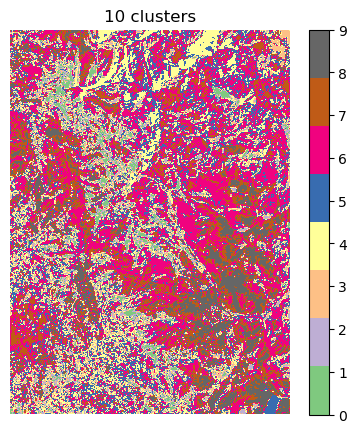

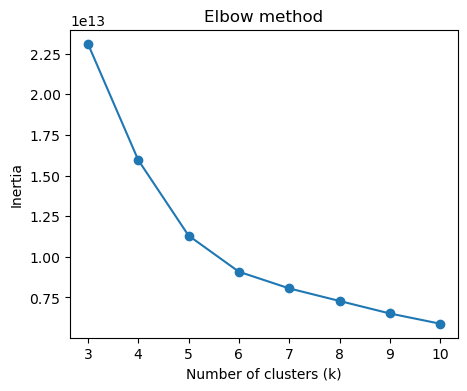

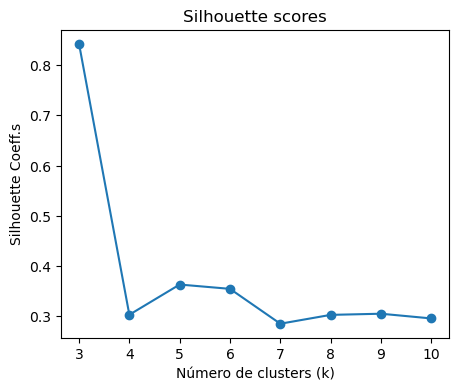

In [5]:
clustered_models.show_clustered()
clustered_models.show_inertia()

ClusteredStack.show_silhouette_scores = ClusteredStack.show_silhouette
clustered_models.show_silhouette_scores()


## Almacenamiento de imagen K_means optima

Para este caso, se graba la imagen que mejor se comporto en las graficas anteriores y así poder utilizarlo
en la generación de clases para el modelo con RandomForest.


In [9]:
import rasterio
from rasterio.transform import from_origin
import numpy as np

# Paso 1: Obtener imagen clasificada de k=5
k_index = clustered_models.k_range.index(5)  # Encuentra índice del k=5
cluster_k5 = clustered_models.predicted_rasters[k_index]  # shape: (rows, cols)

# Paso 2: Extraer metadatos desde la imagen original
with rasterio.open(subset_path) as src:
    profile = src.profile.copy()
    transform = src.transform
    crs = src.crs
    width = src.width
    height = src.height

# Paso 3: Actualizar perfil para 1 banda y tipo de dato adecuado
max_val = cluster_k5.max()
dtype = "uint8" if max_val <= 255 else "uint16"

profile.update({
    "count": 1,
    "dtype": dtype,
    "width": width,
    "height": height,
    "transform": transform,
    "crs": crs,
    "nodata": 0
})

# Paso 4: Exportar la imagen clasificada alineada
output_path = "/notebooks/Workshop_5/kmeans_k5_aligned.tif"
with rasterio.open(output_path, "w", **profile) as dst:
    dst.write(cluster_k5.astype(dtype), 1)

print("✅ Imagen KMeans (k=5) exportada y alineada:", output_path)


✅ Imagen KMeans (k=5) exportada y alineada: /notebooks/Workshop_5/kmeans_k5_aligned.tif


## Información base para la clasificación con RandomForest



In [22]:
# Import modules from python standard library
import os
import pprint
import random

# Import Geopandas for vector analysis (https://geopandas.org)
import geopandas

# Import the matplotlib plotting module and set it to work within
# a notebook environment.
%matplotlib inline
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Import the RSGISLib modules for the notebook
import rsgislib
import rsgislib.classification
import rsgislib.classification.classsklearn
import rsgislib.tools.filetools
import rsgislib.tools.mapping
import rsgislib.tools.plotting
import rsgislib.vectorutils
import rsgislib.zonalstats
from sklearn.ensemble import RandomForestClassifier

# scikit-learn imports
from sklearn.model_selection import GridSearchCV

# Standard and scientific libraries
import numpy as np
import rasterio as rio
import rasterio.windows as rwin
from rasterio.mask import mask

# Machine-learning tools
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Image-enhancement for visual interpretation
from skimage.exposure import equalize_adapthist

## Definición de las imagenes y bandas para la clasificación

Par lograr incluir la banda de K-Mena, se debe generar una imagen apilada incluyendo una nueva banda a la imagen optica.

En otras palabras, aquí es posible incluir las bandas de la imagen multiespectral y el K-Mean, almacenando su información y ruta.

Adicionalmente, se genera una mascara sobre la imgen satelital, para poder tratar el restante de la clasifiación.


In [15]:
import rasterio
import numpy as np

# Rutas
subset_path = "/notebooks/Workshop_5/subset_by_shape.tif"
kmeans_path = "/notebooks/Workshop_5/kmeans_k5_aligned.tif"
output_stack = "/notebooks/Workshop_5/subset_plus_k5stack.tif"

# Abrir imagen satelital (9 bandas)
with rasterio.open(subset_path) as src_subset:
    subset_data = src_subset.read()  # shape: (9, rows, cols)
    profile = src_subset.profile.copy()

# Abrir imagen de KMeans (1 banda)
with rasterio.open(kmeans_path) as src_kmeans:
    kmeans_band = src_kmeans.read(1)  # shape: (rows, cols)


In [16]:
# Expandimos la dimensión de kmeans para que sea (1, rows, cols)
kmeans_band_exp = np.expand_dims(kmeans_band, axis=0)

# Concatenamos para formar imagen de 10 bandas
stacked_img = np.concatenate((subset_data, kmeans_band_exp), axis=0)


In [18]:
# Verificamos el tipo de dato adecuado
max_val = kmeans_band.max()
dtype_out = "uint8" if max_val <= 255 else "uint16"

# Ajustamos el perfil
profile.update({
    "count": stacked_img.shape[0],
    "dtype": dtype_out,
    "nodata": 0  # o puedes usar 255 si 0 tiene significado válido
})

# Guardar imagen apilada
with rasterio.open(output_stack, "w", **profile) as dst:
    for i in range(stacked_img.shape[0]):
        dst.write(stacked_img[i].astype(dtype_out), i + 1)

print("✅ Imagen multibanda (9 bandas + KMeans) guardada en:", output_stack)


✅ Imagen multibanda (9 bandas + KMeans) guardada en: /notebooks/Workshop_5/subset_plus_k5stack.tif


In [14]:
import rasterio
import numpy as np

# Ruta de entrada y salida
input_img = "/notebooks/Workshop_5/subset_by_shape.tif"
mask_out = "/notebooks/Workshop_5/subset_by_shape_mask1.tif"

with rasterio.open(input_img) as src:
    img = src.read()  # (bands, rows, cols)
    profile = src.profile.copy()
    nodata_val = src.nodata

# Crear máscara: 1 si todos los valores en las bandas son distintos de NoData
valid_mask = np.all(img != nodata_val, axis=0).astype("uint8")

# Actualizar metadatos para una sola banda uint8
profile.update({
    "count": 1,
    "dtype": "uint8",
    "nodata": 0
})

# Guardar la máscara binaria como GeoTIFF
with rasterio.open(mask_out, "w", **profile) as dst:
    dst.write(valid_mask, 1)

print("✅ Máscara guardada en:", mask_out)


✅ Máscara guardada en: /notebooks/Workshop_5/subset_by_shape_mask1.tif


## Rutas para la clasificación


In [23]:
input_img = "/notebooks/Workshop_5/subset_plus_k5stack.tif"

in_msk_img = "/notebooks/Workshop_5/subset_by_shape_mask1.tif"

vec_train_file = "/notebooks/Workshop_5/Prueba_clase1.gpkg"

## Definición de las clases y el vector de muestreo

Aquí se hace la creación de la lista de objetos "ClassVecSamplesInfoObj" 
para su posterior almacenamiento en los archivos h5 y se parte de las clases identificadas en el vector de entrenamiento.


In [27]:
img_band_info = list()
img_band_info.append(
    rsgislib.imageutils.ImageBandInfo(
        file_name=input_img, name="sen2", bands=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    )
)
print(img_band_info)

[('sen2', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], '/notebooks/Workshop_5/subset_plus_k5stack.tif')]


In [28]:
class_vec_sample_info = list()

forest_h5 = "forest_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=0,
        class_name="forest",
        vec_file=vec_train_file,
        vec_lyr="forest",
        file_h5=forest_h5,
    )
)

shrub_or_herbaceous_vegetation_h5 = "shrub_or_herbaceous_vegetation_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=1,
        class_name="shrub_or_herbaceous_vegetation",
        vec_file=vec_train_file,
        vec_lyr="shrub_or_herbaceous_vegetation",
        file_h5=shrub_or_herbaceous_vegetation_h5,
    )
)

sparsely_or_no_vegetated_areas_h5 = "sparsely_or_no_vegetated_areas_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=2,
        class_name="sparsely_or_no_vegetated_areas",
        vec_file=vec_train_file,
        vec_lyr="sparsely_or_no_vegetated_areas",
        file_h5=sparsely_or_no_vegetated_areas_h5,
    )
)

water_bodies_h5 = "water_bodies_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=3,
        class_name="water_bodies",
        vec_file=vec_train_file,
        vec_lyr="water_bodies",
        file_h5=water_bodies_h5,
    )
)

clouds_h5 = "clouds_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=4,
        class_name="clouds",
        vec_file=vec_train_file,
        vec_lyr="clouds",
        file_h5=clouds_h5,
    )
)

ice_and_snow_h5 = "ice_and_snow.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=5,
        class_name="ice_and_snow",
        vec_file=vec_train_file,
        vec_lyr="ice_and_snow",
        file_h5=ice_and_snow_h5,
    )
)

print(class_vec_sample_info)


[<rsgislib.classification.ClassVecSamplesInfoObj object at 0x750119d43c90>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x750119cd2c90>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x750119d49c50>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x750119d4a410>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x750119d4a290>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x750119d58190>]


## Creación de un directorio de salida temporal



In [29]:
tmp_dir = "./tmp"

if not os.path.exists(tmp_dir):
    os.mkdir(tmp_dir)
    

## Extracción de muestras

Mediante "classification.get_class_training_data", e sposible extarer las muestras para cada archivo creado,
lo que permite empezar a extraer información de la imagen multiespectral respecto al vector de entrenamiento.


In [30]:
cls_smpls_info = rsgislib.classification.get_class_training_data(
    img_band_info, class_vec_sample_info, tmp_dir, ref_img=in_msk_img
)


Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Creating output image using input image
Running Rasterise now...
Calculating Image Pyramids.



Get Image Min and Max.

Creating output image using input image
Running Rasterise now...
Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Get Image Min and Max.

Creating output image using input image
Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Running Rasterise now...
Creating output image using input image
Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Get Image Min and Max.

Creating output image using input image
Running Rasterise now...
Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Get Image Min and Max.

Get Image Histogram.

Adding H

## Definición de clases de color



In [31]:
cls_smpls_info["clouds"].red = 6
cls_smpls_info["clouds"].green = 198
cls_smpls_info["clouds"].blue = 82

cls_smpls_info["forest"].red = 150
cls_smpls_info["forest"].green = 17
cls_smpls_info["forest"].blue = 32

cls_smpls_info["shrub_or_herbaceous_vegetation"].red = 75
cls_smpls_info["shrub_or_herbaceous_vegetation"].green = 57
cls_smpls_info["shrub_or_herbaceous_vegetation"].blue = 63

cls_smpls_info["sparsely_or_no_vegetated_areas"].red = 5
cls_smpls_info["sparsely_or_no_vegetated_areas"].green = 202
cls_smpls_info["sparsely_or_no_vegetated_areas"].blue = 147

cls_smpls_info["water_bodies"].red = 74
cls_smpls_info["water_bodies"].green = 75
cls_smpls_info["water_bodies"].blue = 85

cls_smpls_info["ice_and_snow"].red = 243
cls_smpls_info["ice_and_snow"].green = 1
cls_smpls_info["ice_and_snow"].blue = 59

cls_smpls_info


{'forest': 0: forest_smpls.h5, (150, 17, 32),
 'shrub_or_herbaceous_vegetation': 1: shrub_or_herbaceous_vegetation_smpls.h5, (75, 57, 63),
 'sparsely_or_no_vegetated_areas': 2: sparsely_or_no_vegetated_areas_smpls.h5, (5, 202, 147),
 'water_bodies': 3: water_bodies_smpls.h5, (74, 75, 85),
 'clouds': 4: clouds_smpls.h5, (6, 198, 82),
 'ice_and_snow': 5: ice_and_snow.h5, (243, 1, 59)}

## Comprobar muestras extraidas

Es posible validar que muestras se extrajeron de cada clase creada con anterioridad, por lo que unicamente se obtendran valores respecto a los nombres que se vincualn con la capa de entrenamiento



In [33]:
for cls_name in cls_smpls_info:
    smpls_h5_file = cls_smpls_info[cls_name].file_h5
    n_smpls = rsgislib.classification.get_num_samples(smpls_h5_file)
    print(f"{cls_name}: {n_smpls}")

forest: 12057192
shrub_or_herbaceous_vegetation: 7152
sparsely_or_no_vegetated_areas: 5996
water_bodies: 416
clouds: 3682
ice_and_snow: 6409


## Balance y extracción de conjuntos de datos de entrenamiento, validación y prueba

En este caso se mantienen los subgrupos propuestos de Training, Validation y Testing. Esto permmite ingresar a detallar los valores obtenidos por cada clase respecto a estos elementos.

| Subset | Purpose |
|--------|---------|
| **Training** | Fit the Random-Forest parameters. | 
| **Validation** | Tune hyper-parameters, spot overfitting. |
| **Testing** | Provide an unbiased accuracy figure at the very end.  |



In [34]:
# Definición del directorio de salida para estos archivos
smpls_dir = "/notebooks/Workshop_5/Clases"

if not os.path.exists(smpls_dir):
    os.mkdir(smpls_dir)


cls_smpls_fnl_info = rsgislib.classification.get_class_info_dict(
    cls_smpls_info, smpls_dir
)

print("\n keys",cls_smpls_fnl_info.keys())

# print the values of artificail_surfaces
print("\n keys",cls_smpls_fnl_info["forest"])


0=0: (Train:/notebooks/Workshop_5/Clases/forest_smpls_train.h5, Test:/notebooks/Workshop_5/Clases/forest_smpls_test.h5, Valid:/notebooks/Workshop_5/Clases/forest_smpls_valid.h5), (150, 17, 32)
1=1: (Train:/notebooks/Workshop_5/Clases/shrub_or_herbaceous_vegetation_smpls_train.h5, Test:/notebooks/Workshop_5/Clases/shrub_or_herbaceous_vegetation_smpls_test.h5, Valid:/notebooks/Workshop_5/Clases/shrub_or_herbaceous_vegetation_smpls_valid.h5), (75, 57, 63)
2=2: (Train:/notebooks/Workshop_5/Clases/sparsely_or_no_vegetated_areas_smpls_train.h5, Test:/notebooks/Workshop_5/Clases/sparsely_or_no_vegetated_areas_smpls_test.h5, Valid:/notebooks/Workshop_5/Clases/sparsely_or_no_vegetated_areas_smpls_valid.h5), (5, 202, 147)
3=3: (Train:/notebooks/Workshop_5/Clases/water_bodies_smpls_train.h5, Test:/notebooks/Workshop_5/Clases/water_bodies_smpls_test.h5, Valid:/notebooks/Workshop_5/Clases/water_bodies_smpls_valid.h5), (74, 75, 85)
4=4: (Train:/notebooks/Workshop_5/Clases/clouds_smpls_train.h5, Test

Para este caso, se crean estos subgrupos para poder empezar el proceso de clasificación y su entrenamiento.


In [35]:
rsgislib.classification.create_train_valid_test_sets(
    cls_smpls_info, cls_smpls_fnl_info, 50, 50, 300)


In [36]:
print("Muestras finales por clase (entrenamiento / validación / prueba):\n")

for clase, info in cls_smpls_fnl_info.items():
    n_train = rsgislib.classification.get_num_samples(info.train_file_h5)
    n_valid = rsgislib.classification.get_num_samples(info.valid_file_h5)
    n_test = rsgislib.classification.get_num_samples(info.test_file_h5)

    print(f"🔸 {clase}")
    print(f"   Entrenamiento : {n_train}")
    print(f"   Validación    : {n_valid}")
    print(f"   Prueba        : {n_test}\n")

Muestras finales por clase (entrenamiento / validación / prueba):

🔸 forest
   Entrenamiento : 12034
   Validación    : 12046
   Prueba        : 12058

🔸 shrub_or_herbaceous_vegetation
   Entrenamiento : 304
   Validación    : 57
   Prueba        : 51

🔸 sparsely_or_no_vegetated_areas
   Entrenamiento : 301
   Validación    : 53
   Prueba        : 54

🔸 water_bodies
   Entrenamiento : 300
   Validación    : 50
   Prueba        : 50

🔸 clouds
   Entrenamiento : 301
   Validación    : 51
   Prueba        : 52

🔸 ice_and_snow
   Entrenamiento : 303
   Validación    : 51
   Prueba        : 52



# Entrenamiento del clasificador

Para optimizar el metodo de clasificación, se han de seleccionar unos hiperparametros, en este caso para Random Forest.


In [37]:
grid_search = GridSearchCV(
    RandomForestClassifier(),
    param_grid={
        "n_estimators": [10, 20, 50, 100, 150, 200],
        "max_depth": [4, 8, 10, 12, 14, 16],
    },
)
print(grid_search )
sk_classifier = (
    rsgislib.classification.classsklearn.perform_sklearn_classifier_param_search(
        cls_smpls_fnl_info, grid_search
    )
)


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 8, 10, 12, 14, 16],
                         'n_estimators': [10, 20, 50, 100, 150, 200]})
Training data size: 12308 x 10
Best score was 0.9813130654621519 and has parameters {'max_depth': 12, 'n_estimators': 10}.


## Entrenar el clasificador optimizado


In [38]:
rsgislib.classification.classsklearn.train_sklearn_classifier(
    cls_smpls_fnl_info, sk_classifier
)

Training data size: 13543 x 10
Testing data size: 12317 x 10
Training Classifier
Completed
Calc Classifier Accuracy
Classifier Train Score = 96.37%
Classifier Test Score = 98.38%


(0.9636712692904084, 0.9837622797759195)

# Aplicación del clasificador

Luego de optimizar el clasificador, es posible aplicar este al restante de la información, para generalizar los elementos obtenidos.



In [39]:
from osgeo import gdal
from rsgislib.classification import ImageBandInfo
import rsgislib.classification.classsklearn as cls_sklearn

# === 1. Rutas adaptadas a tu entorno ===
input_img = "/notebooks/Workshop_5/subset_plus_k5stack.tif"  # Imagen apilada con KMeans
in_msk_img = "/notebooks/Workshop_5/subset_by_shape_mask1.tif"  # Máscara binaria válida
out_cls_img = "/notebooks/Workshop_5/clasificacion_rf_k5.kea"
out_scr_img = "/notebooks/Workshop_5/clasificacion_rf_k5_score.kea"

# === 2. Leer número de bandas ===
ds = gdal.Open(input_img)
n_bands = ds.RasterCount
ds = None  # cerrar archivo

# === 3. Crear objeto ImageBandInfo ===
img_band_info = [ImageBandInfo(name="sen2_kmean", file_name=input_img, bands=[i+1 for i in range(n_bands)])]

# === 4. Aplicar el clasificador Random Forest ===
cls_sklearn.apply_sklearn_classifier(
    cls_train_info=cls_smpls_fnl_info,  # clases
    sk_classifier=sk_classifier,       # modelo entrenado
    in_msk_img=in_msk_img,             # máscara válida
    img_msk_val=1,                     # valor válido (255 si así guardaste la máscara)
    img_file_info=img_band_info,       # bandas
    out_class_img=out_cls_img,         # salida clasificación
    gdalformat="KEA",
    out_score_img=out_scr_img,         # salida de puntuaciones
    class_clr_names=True,
    ignore_consec_cls_ids=True
)


Applying the Classifier


  0%|          | 0/100 [00:00<?, ?it/s]

Completed
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Calculating Image Pyramids.






Apply Colour to class 'forest'
Apply Colour to class 'shrub_or_herbaceous_vegetation'
Apply Colour to class 'sparsely_or_no_vegetated_areas'
Apply Colour to class 'water_bodies'
Apply Colour to class 'clouds'
Apply Colour to class 'ice_and_snow'


# Visualización de los resultados de clasificación


Image Data Size: 2961 x 4072


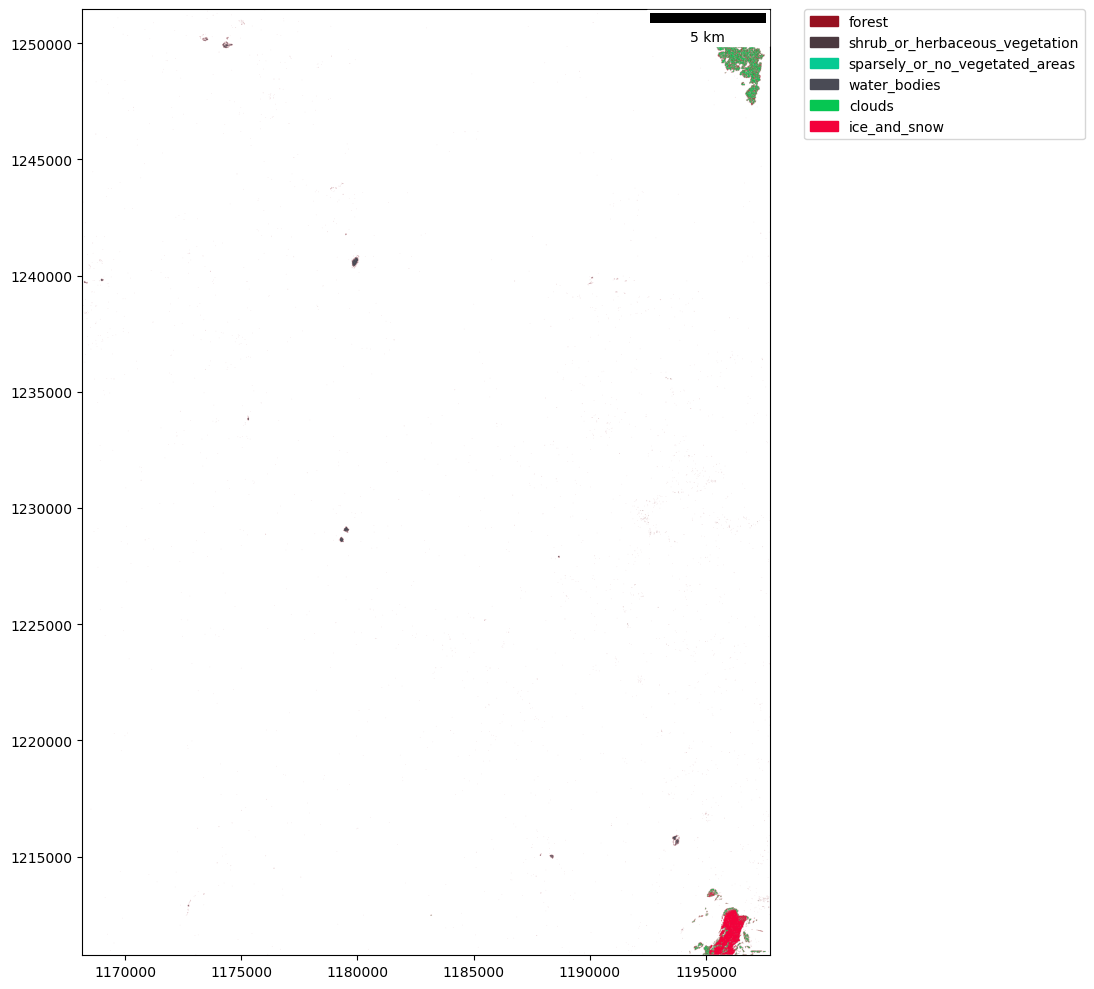

In [53]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import rsgislib.tools.mapping

# Diccionario de clases y colores RGB (ejemplo)
class_labels = {
    "forest": (150, 17, 32),
 "shrub_or_herbaceous_vegetation": (75, 57, 63),
 "sparsely_or_no_vegetated_areas": (5, 202, 147),
 "water_bodies": (74, 75, 85),
 "clouds": (6, 198, 82),
 "ice_and_snow": (243, 1, 59)
}

# Convertir los colores RGB (0–255) a formato 0–1
def rgb_to_mpl(rgb):
    return tuple([v/255 for v in rgb])

# Crear figura
fig, ax = plt.subplots(figsize=(10, 10))

# Mapa clasificado
rsgislib.tools.mapping.create_thematic_raster_map(
    ax=ax,
    input_img="/notebooks/Workshop_5/clasificacion_rf_k5.kea"
)

# Crear leyenda personalizada
legend_patches = [
    mpatches.Patch(color=rgb_to_mpl(rgb), label=label)
    for label, rgb in class_labels.items()
]

# Añadir leyenda fuera del mapa
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

# Comparación entre RandomForest con y sin K-Mean

La imagen de la derecha es la obtenida sin K-Mean como covariable, mostrando las clases presentes, sin embargo, la clasificación obtenida con K-Mean no genera un resultado coherente,
porque no muestra todas las clases que debeian aparecer. Lo que genera un conflicto para los siguientes calculos.



Image Data Size: 2961 x 4072
Image Data Size: 2961 x 4072


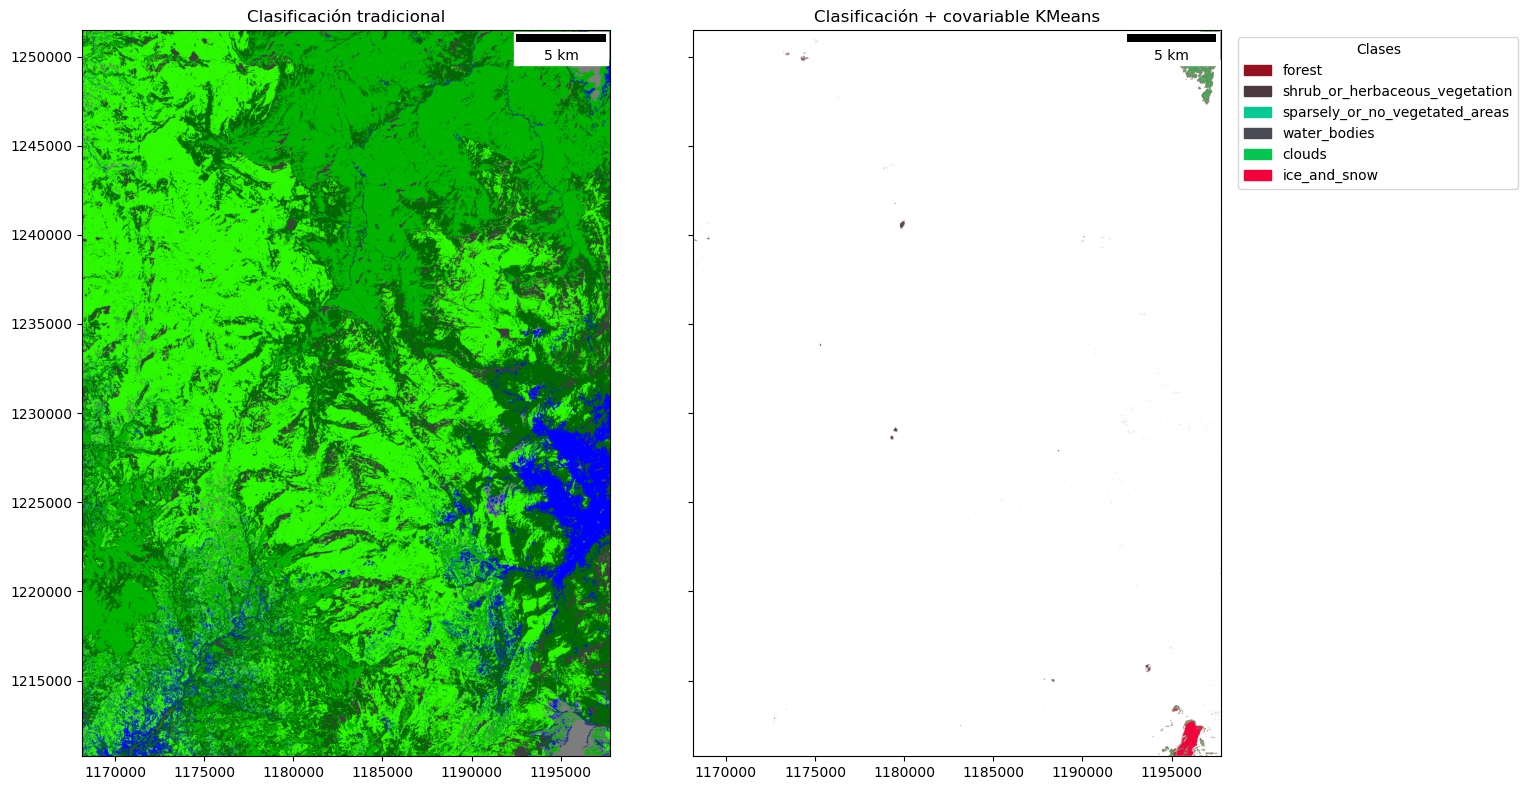

In [43]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import rsgislib
from rsgislib import tools

# === Diccionario de clases y colores RGB (0–255)
class_labels = {
    "forest": (150, 17, 32),
 "shrub_or_herbaceous_vegetation": (75, 57, 63),
 "sparsely_or_no_vegetated_areas": (5, 202, 147),
 "water_bodies": (74, 75, 85),
 "clouds": (6, 198, 82),
 "ice_and_snow": (243, 1, 59)
}

# Convertir RGB 255 → 0–1 (para matplotlib)
def rgb_to_mpl(rgb):
    return tuple([v/255 for v in rgb])

# Ruta de las dos imágenes a comparar
img_clasica = "/notebooks/Workshop_5/Sentinel_Santander_2020_cls.kea"
img_con_kmeans = "/notebooks/Workshop_5/clasificacion_rf_k5.kea"

# Bounding box de la zona de análisis
sub_img_bbox = [1168140.0, 1197750.0, 1210750.0, 1251470.0]

# === Crear figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Mapa clasificado tradicional
tools.mapping.create_thematic_raster_map(
    ax=ax1,
    input_img=img_clasica,
    bbox=sub_img_bbox
)
ax1.set_title("Clasificación tradicional")

# Mapa clasificado con covariable KMeans
tools.mapping.create_thematic_raster_map(
    ax=ax2,
    input_img=img_con_kmeans,
    bbox=sub_img_bbox
)
ax2.set_title("Clasificación + covariable KMeans")

# Crear parches de la leyenda (una sola para ambos mapas)
legend_patches = [
    mpatches.Patch(color=rgb_to_mpl(rgb), label=label)
    for label, rgb in class_labels.items()
]

# Añadir leyenda en el centro derecho
ax2.legend(
    handles=legend_patches,
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    title="Clases"
)

plt.tight_layout()
plt.show()

# Estimación de metricas de precisión

Para este paso se hace uso de una capa de puntos de validación.



In [44]:
vec_file = "/notebooks/Workshop_5/centroides1.gpkg"
vec_lyr = "centroides"


Creación de los directorios de salida.


In [45]:
out_pts_dir = "acc_pts"
if not os.path.exists(out_pts_dir):
    os.mkdir(out_pts_dir)
    
out_stats_dir = "acc_stats"
if not os.path.exists(out_stats_dir):
    os.mkdir(out_stats_dir)
    

In [ ]:
"forest": (150, 17, 32),
 "shrub_or_herbaceous_vegetation": (75, 57, 63),
 "sparsely_or_no_vegetated_areas": (5, 202, 147),
 "water_bodies": (74, 75, 85),
 "clouds": (6, 198, 82),
 "ice_and_snow": (243, 1, 59)

para evitar perdidas o daños en el archivo original, se crea un archiv auxiliar GeoJSON.


In [46]:
vec_refpts_file = os.path.join(out_pts_dir, "Puntos1.geojson")
vec_refpts_lyr = "centroides"

rsgislib.vectorutils.vector_translate(vec_file, vec_lyr, vec_refpts_file, vec_refpts_lyr, out_format="GeoJSON", del_exist_vec=True)


  1%|▊                                                                                  | 1/100 [00:00<00:08, 11.96it/s]


In [51]:
# Leer la capa
points_gdf = gpd.read_file(vec_file, layer=vec_lyr)

rename_map = {
    3: "forest",
    4: "shrub_or_herbaceous_vegetation",
    5: "sparsely_or_no_vegetated_areas",
    6: "water_bodies",
    9: "clouds",
    8: "ice_and_snow"
}

# Reemplazar los valores en la columna "Reference"
points_gdf["Name"] = points_gdf["Name"].replace(rename_map)
# Sobrescribir la misma capa en el mismo archivo
points_gdf.to_file(vec_file, layer=vec_lyr, driver="GPKG")

In [55]:
import geopandas as gpd
from rasterstats import point_query  # ✅ IMPORTANTE

# Leer la capa
points_gdf = gpd.read_file(vec_file, layer=vec_lyr)

rename_map = {
    3: "forest",
    4: "shrub_or_herbaceous_vegetation",
    5: "sparsely_or_no_vegetated_areas",
    6: "water_bodies",
    9: "clouds",
    8: "ice_and_snow"
}

# Extraer valores del raster clasificado
raster_path = "/notebooks/Workshop_5/clasificacion_rf_k5.kea"
points_gdf["Classified"] = point_query(points_gdf, raster_path, interpolate='nearest')

# Reemplazar los valores numéricos por nombres
points_gdf["Classified"] = points_gdf["Classified"].replace(rename_map)

# Guardar en el mismo archivo
points_gdf.to_file(vec_file, layer=vec_lyr, driver="GPKG")


In [59]:
# Archivo de salida en GeoJSON
vec_refpts_file = os.path.join(out_pts_dir, "cls_acc_assessment_pts_ref.geojson")
vec_refpts_lyr = "cls_acc_assessment_pts_ref"

# Exportar la capa desde el GPKG a GeoJSON
rsgislib.vectorutils.vector_translate(
    vec_file=vec_file,
    vec_lyr="centroides", 
    out_vec_file=vec_refpts_file,
    out_vec_lyr=vec_refpts_lyr,
    out_format="GeoJSON",
    del_exist_vec=True
)

print("Puntos de evaluación exportados a GeoJSON correctamente.")


  1%|▊                                                                                  | 1/100 [00:00<00:09, 10.72it/s]

Puntos de evaluación exportados a GeoJSON correctamente.


In [62]:
from rasterio import open as rio_open
from shapely.geometry import box

# Bounding box del raster
with rio_open(out_cls_img) as src:
    bounds = src.bounds
    raster_box = box(*bounds)

# Leer y filtrar puntos
gdf = gpd.read_file(vec_refpts_file)
gdf = gdf[gdf.geometry.within(raster_box)]

# Guardar los puntos filtrados
gdf.to_file("acc_pts/cls_acc_assessment_pts_ref_filtered.geojson", driver="GeoJSON")


In [65]:
out_cls_img = "/notebooks/Workshop_5/clasificacion_rf_k5.kea"
vec_refpts_file = "acc_pts/cls_acc_assessment_pts_ref_filtered.geojson"
vec_refpts_lyr = "cls_acc_assessment_pts_ref_filtered"

rsgislib.classification.pop_class_info_accuracy_pts(
    input_img=out_cls_img,
    vec_file=vec_refpts_file,
    vec_lyr=vec_refpts_lyr,
    rat_class_col="class_names",
    vec_class_col="Classified2",  # usa la nueva columna creada
    vec_ref_col=None,
    vec_process_col=None
)


In [68]:
vec_refpts_vld_file = os.path.join(out_pts_dir, "cls_acc_assessment_pts_ref_vld.geojson")
vec_refpts_vld_lyr = "cls_acc_assessment_pts_ref_vld"
print(points_gdf )
points_gdf = points_gdf.drop(points_gdf[points_gdf["Classified"] == "NA"].index)
points_gdf.to_file(vec_refpts_vld_file, driver="GeoJSON")

                    Name                         geometry Classified
0    artificial_surfaces  POINT (1148813.897 1232802.524)        NaN
1    artificial_surfaces  POINT (1148980.302 1232665.775)        NaN
2    artificial_surfaces  POINT (1148793.576 1233215.517)        NaN
3    artificial_surfaces  POINT (1148815.698 1233295.106)        NaN
4    artificial_surfaces  POINT (1148681.783 1233753.089)        NaN
..                   ...                              ...        ...
554         water_bodies  POINT (1175285.342 1233800.821)     forest
555         water_bodies  POINT (1166510.017 1245135.541)        NaN
556         water_bodies  POINT (1168391.101 1252030.776)        NaN
557         water_bodies   POINT (1173155.084 1253543.23)        NaN
558         water_bodies  POINT (1120671.159 1242420.737)        NaN

[559 rows x 3 columns]


In [86]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Asegúrate de que no haya NaN
points_gdf_valid = points_gdf.dropna(subset=["Name", "Classified"])

# Reporte de clasificación
report = classification_report(points_gdf_valid["Name"], points_gdf_valid["Classified"], digits=3)
print("Reporte de clasificación:\n", report)

# Matriz de confusión
labels = sorted(points_gdf_valid["Name"].unique())
cm = confusion_matrix(points_gdf_valid["Name"], points_gdf_valid["Classified"], labels=labels)

# Mostrar matriz como DataFrame
conf_df = pd.DataFrame(cm, index=labels, columns=labels)
print("Matriz de confusión:\n", conf_df)


Reporte de clasificación:
                                 precision    recall  f1-score   support

                        clouds      0.000     0.000     0.000       8.0
                        forest      0.000     0.000     0.000       0.0
                  ice_and_snow      0.000     0.000     0.000      20.0
shrub_or_herbaceous_vegetation      0.000     0.000     0.000       0.0
sparsely_or_no_vegetated_areas      0.000     0.000     0.000       0.0
                  water_bodies      0.000     0.000     0.000       3.0

                      accuracy                          0.000      31.0
                     macro avg      0.000     0.000     0.000      31.0
                  weighted avg      0.000     0.000     0.000      31.0

Matriz de confusión:
               clouds  ice_and_snow  water_bodies
clouds             0             0             0
ice_and_snow       0             0             0
water_bodies       0             0             0


/opt/miniconda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda/lib/python3.11/site-packages/s

Finalmnete, por los resultados obtenidos se evidencia que la clasifiación obtenida, fue de muy bajo rendimiento, pues no logro clasificar los elementos visibles, en comparación a la imagen original.

Por otro lado, esto genero, que los resultados de las emtricas fueran todos 0, pues las muestras y comparaicón entre los puntos y sus clasifiaciones fueron muy pocos y practicamente nulos.

Es posible, que se haya visto un sobremuestreo en algunas categorías que egeneraron algun daño y coherencia en la clasifiación final.

